# Convolutional Neural Networks
A CNN is made up of basic building blocks defined as tensor, neurons, layers and kernel weights and biases. In this lab, we use PyTorch to build a image classifier using CNN. The objective is to learn CNN using PyTorch framework.
Please refer to the link below for know more about CNN
https://poloclub.github.io/cnn-explainer/


## Import necessary libraries

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from  torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import random_split
from torch.utils.data.sampler import SubsetRandomSampler
%matplotlib inline

### Download the MNIST dataset. 

In [3]:
# choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True,download=True, transform=ToTensor())
test_data = datasets.MNIST(root='data', train=False,download=True, transform=ToTensor())

##Chopping training datasets in train set and validation set. This is done to avoid overfitting on the test set.

Use simple algorithm to create validation set:
First, create a list of indices of the training data. Then randomly shuffle those indices. Lastly,split the indices in 80-20.



In [8]:
indices = np.arange(len(train_data))
np.random.shuffle(indices)
train_indices = indices[:int(len(indices)*0.8)]
test_indices = indices[len(train_indices):]

## Print data size

In [5]:
print(train_data)
print(test_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


## Data Visualization

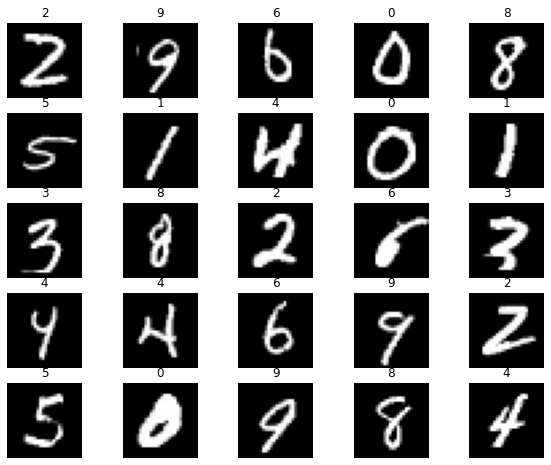

In [6]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Data preparation for training with PyTorch DataLoaders 

In [10]:
# Obtaining training and validation batches
train_batch = SubsetRandomSampler(train_indices)
val_batch = SubsetRandomSampler(test_indices)

# Samples per batch to load
batch_size = 256

# Training Set 
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size,sampler=train_batch,num_workers=4,pin_memory=True)
# Validation Set 
val_loader = torch.utils.data.DataLoader(dataset=train_data,batch_size=batch_size, sampler=val_batch, num_workers=4,pin_memory=True)
# Test Set  
test_loader = torch.utils.data.DataLoader(dataset=test_data,batch_size=batch_size,num_workers=4,pin_memory=True)

## Data normalization step: Calculate Mean and Std

In [11]:
train_mean = 0.
train_std = 0.
for images, _ in train_loader:
    batch_samples = images.size(0) # batch size (the last batch can have smaller size!)
    images = images.view(batch_samples, images.size(1), -1)

    train_mean += images.mean(2).sum(0)
    train_std += images.std(2).sum(0)

train_mean /= len(train_loader.dataset)
train_std /= len(train_loader.dataset)

print('Mean: ', train_mean)
print('Std: ', train_std)

Mean:  tensor([0.1044])
Std:  tensor([0.2411])


## Data Augmentation: 
It is usually done to increase the performance of the CNN based classifiers. Consider this is preprocess of the data. PyTorch inculdes lots of pre-built data augumentation and data transformation features such as Below are the list of transformations that come pre-built with PyTorch: ToTensor, Normalize, Scale, RandomCrop, LinearTransformation, RandomGrayscale, etc. Try to use atleaset one the data.

In [ ]:
# Your code

# Check the data and see weither suggested augumenation is done. Also check for normalization transformation.

## Evaluation Metrics
prediction acuracy

In [12]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

## Use different form of evaluation meterics 

## Loss Function: Cross Entropy
For each output row, pick the predicted probability for the correct label. E.g. if the predicted probabilities for an image are [0.1, 0.3, 0.2, ...] and the correct label is 1, we pick the corresponding element 0.3 and ignore the rest.

Then, take the logarithm of the picked probability. If the probability is high i.e. close to 1, then its logarithm is a very small negative value, close to 0. And if the probability is low (close to 0), then the logarithm is a very large negative value. We also multiply the result by -1, which results is a large postive value of the loss for poor predictions.

Finally, take the average of the cross entropy across all the output rows to get the overall loss for a batch of data.


In [15]:
class MnistModelBase(nn.Module):
    def training_step(self, batch):
        pass
        # your code
    
    def validation_step(self, batch):
           pass
        # your code
    def validation_epoch_end(self, outputs):
        pass
        #your code
    
    def epoch_end(self, epoch, result,LR):
        pass   
        #your code

## Convolutional Neural Network model
we will use a convolutional neural network, using the nn.Conv2d class from PyTorch. The activation function we'll use here is called a Rectified Linear Unit or ReLU, and it has a really simple formula: relu(x) = max(0,x) i.e. if an element is negative, we replace it by 0, otherwise we leave it unchanged. To define the model, we extend the nn.Module class

In [16]:
class MnistModel(MnistModelBase):
    """Feedfoward neural network with 2 hidden layer"""
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size=3),   #RF - 3x3 # 26x26
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(0.1),

            nn.Conv2d(16, 16, 3),   #RF - 5x5 # 24x24
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(0.1),

            nn.Conv2d(16, 32, 3),   #RF - 7x7 # 22x22
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout2d(0.1),
        )

        # translation layer
        # input - 22x22x64; output - 11x11x32
        self.trans1 = nn.Sequential(
            # RF - 7x7
            nn.Conv2d(32, 20, 1), # 22x22
            nn.ReLU(),
            nn.BatchNorm2d(20),


            # RF - 14x14
            nn.MaxPool2d(2, 2), # 11x11
        )

        self.conv2 = nn.Sequential(
            
            nn.Conv2d(20,20,3,padding=1),   #RF - 16x16 #output- 9x9
            nn.ReLU(),
            nn.BatchNorm2d(20),
            nn.Dropout2d(0.1),

            nn.Conv2d(20,16,3),   #RF - 16x16 #output- 9x9
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(0.1),

            nn.Conv2d(16, 16, 3),   #RF - 18x18 #output- 7x7
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(0.1),
        ) 

         
        self.conv3 = nn.Sequential(
            nn.Conv2d(16,16,3),   #RF - 20x20  #output- 5x5
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(0.1),

            #nn.Conv2d(16,10,1),   #RF - 20x20  #output- 7x7

        )   

        # GAP Layer
        self.avg_pool = nn.Sequential(
            # # RF - 22x22
            nn.AvgPool2d(5)
        )   ## output_size=1  

        self.conv4 = nn.Sequential(
  
            nn.Conv2d(16,10,1),   #RF - 20x20  #output- 7x7

        )  

        
    def forward(self, xb):
        x = self.conv1(xb)
        x = self.trans1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.avg_pool(x)
        x = self.conv4(x)

        x = x.view(-1, 10)
        return x

### Using a GPU


In [17]:
#function to ensure that our code uses the GPU if available, and defaults to using the CPU if it isn't.
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
# a function that can move data and model to a chosen device.    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


#Finally, we define a DeviceDataLoader class to wrap our existing data loaders and move data to the selected device, 
#as a batches are accessed. Interestingly, we don't need to extend an existing class to create a PyTorch dataloader. 
#All we need is an __iter__ method to retrieve batches of data, and an __len__ method to get the number of batches.

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

We can now wrap our data loaders using DeviceDataLoader.

In [18]:
device = get_default_device()
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

### Model Training




In [19]:
from torch.optim.lr_scheduler import OneCycleLR
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), lr)
    scheduler = OneCycleLR(optimizer, lr, epochs=epochs,steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            scheduler.step()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result,scheduler.get_lr())
        history.append(result)
    return history

Before we train the model, we need to ensure that the data and the model's parameters (weights and biases) are on the same device (CPU or GPU). We can reuse the to_device function to move the model's parameters to the right device.

In [20]:
# Model (on GPU)
model = MnistModel()
to_device(model, device)

MnistModel(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout2d(p=0.1, inplace=False)
    (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout2d(p=0.1, inplace=False)
    (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout2d(p=0.1, inplace=False)
  )
  (trans1): Sequential(
    (0): Conv2d(32, 20, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(20, 20, kernel_size=(3, 3), st

Print Summary of the model

In [21]:
from torchsummary import summary
# print the summary of the model
summary(model, input_size=(1, 28, 28), batch_size=-1)

ModuleNotFoundError: No module named 'torchsummary'

Let's see how the model performs on the validation set with the initial set of weights and biases.

In [ ]:
history = [evaluate(model, val_loader)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_acc': 0.09784581512212753, 'val_loss': 2.312068223953247}]

The initial accuracy is around 10%, which is what one might expect from a randomly intialized model (since it has a 1 in 10 chance of getting a label right by guessing randomly).

We are now ready to train the model. Let's train for 5 epochs and look at the results. We can use a relatively higher learning of 0.01.

In [ ]:
history += fit(10, 0.01, model, train_loader, val_loader)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0] - LR [[0.002807419689919391]], train_loss: 1.8981, val_loss: 1.0482, val_acc: 0.8374


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:1290: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Epoch [1] - LR [[0.007614816441589408]], train_loss: 0.6569, val_loss: 0.1939, val_acc: 0.9616
Epoch [2] - LR [[0.009999986892206093]], train_loss: 0.2529, val_loss: 0.0926, val_acc: 0.9763
Epoch [3] - LR [[0.00949986702017326]], train_loss: 0.1648, val_loss: 0.0663, val_acc: 0.9820
Epoch [4] - LR [[0.008108497258793057]], train_loss: 0.1285, val_loss: 0.0554, val_acc: 0.9846
Epoch [5] - LR [[0.006101455453337134]], train_loss: 0.1099, val_loss: 0.0457, val_acc: 0.9864
Epoch [6] - LR [[0.003876260848128433]], train_loss: 0.0992, val_loss: 0.0439, val_acc: 0.9856
Epoch [7] - LR [[0.0018736405249494478]], train_loss: 0.0933, val_loss: 0.0374, val_acc: 0.9878
Epoch [8] - LR [[0.0004902379993322589]], train_loss: 0.0831, val_loss: 0.0336, val_acc: 0.9898
Epoch [9] - LR [[5.3107793906959594e-08]], train_loss: 0.0811, val_loss: 0.0350, val_acc: 0.9883


## Plot Metrics

In [ ]:
def plot_scores(history):
#     scores = [x['val_score'] for x in history]
    acc = [x['val_acc'] for x in history]
    plt.plot(acc, '-x')
    plt.xlabel('epoch')
    plt.ylabel('acc')
    plt.title('acc vs. No. of epochs');

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

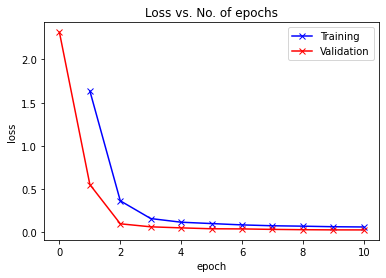

In [ ]:
plot_losses(history)


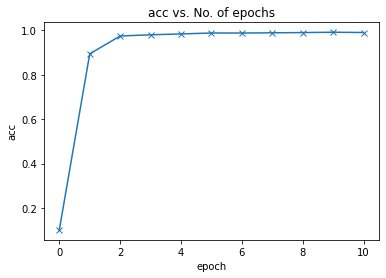

In [ ]:
plot_scores(history)


In [ ]:
def get_misclassified(model, test_loader):
    misclassified = []
    misclassified_pred = []
    misclassified_target = []
    # put the model to evaluation mode
    model.eval()
    # turn off gradients

    with torch.no_grad():
        for data, target in test_loader:

            # do inferencing
            output = model(data)
            # get the predicted output
            pred = output.argmax(dim=1, keepdim=True)

            # get the current misclassified in this batch
            list_misclassified = (pred.eq(target.view_as(pred)) == False)
            batch_misclassified = data[list_misclassified]
            batch_mis_pred = pred[list_misclassified]
            batch_mis_target = target.view_as(pred)[list_misclassified]

            # batch_misclassified =

            misclassified.append(batch_misclassified)
            misclassified_pred.append(batch_mis_pred)
            misclassified_target.append(batch_mis_target)
    # group all the batches together
    misclassified = torch.cat(misclassified)
    misclassified_pred = torch.cat(misclassified_pred)
    misclassified_target = torch.cat(misclassified_target)

    return list(map(lambda x, y, z: (x, y, z), misclassified, misclassified_pred, misclassified_target))

In [ ]:
misclassified = get_misclassified(model, test_loader)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


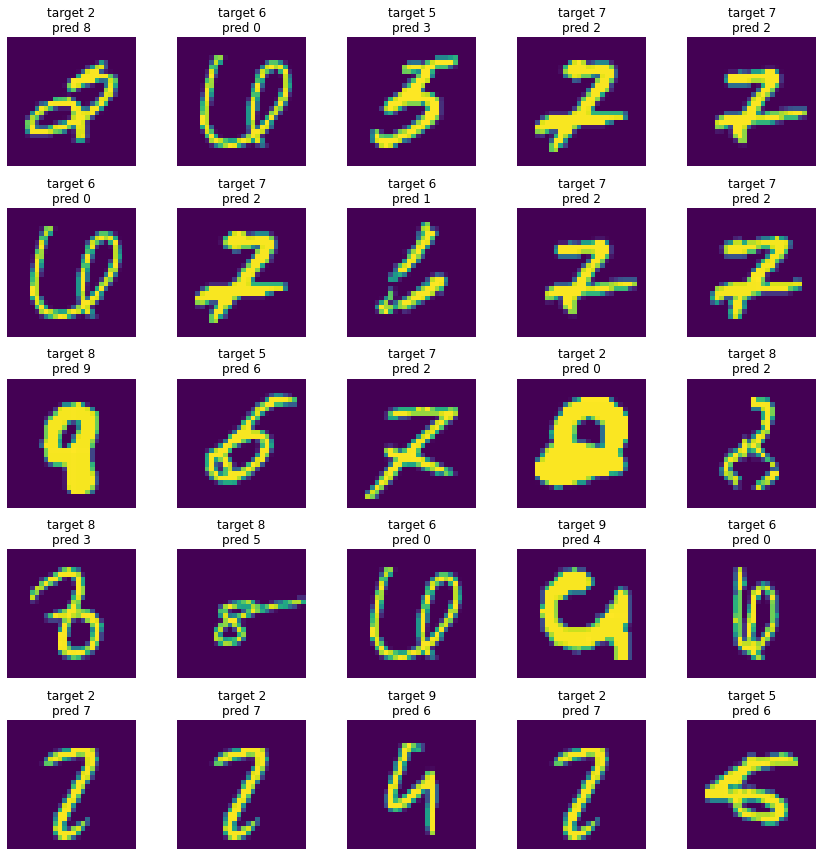

In [ ]:
import random

num_images = 25
fig = plt.figure(figsize=(12, 12))
for idx, (image, pred, target) in enumerate(random.choices(misclassified, k=num_images)):
    image, pred, target = image.cpu().numpy(), pred.cpu(), target.cpu()
    ax = fig.add_subplot(5, 5, idx+1)
    ax.axis('off')
    ax.set_title('target {}\npred {}'.format(target.item(), pred.item()), fontsize=12)
    ax.imshow(image.squeeze())
plt.tight_layout()
plt.show()
